## Train a neural network on heart failure data

###  Recap data preparation from last time

In [27]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split

# look at heart failure data from last class
current_dir = os.getcwd()

heart_data = pd.read_csv("../data/heart_failure/heart_train.csv")
features = heart_data.drop(columns=["HeartDisease"])
label = heart_data["HeartDisease"]

prng = np.random.RandomState(20240311)  # ensure we have the same split as in last class
X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=0.2, random_state=prng)

### Estimate simple logistic regression as a benchmark

In [28]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

# preprocess
one_hot_encoder = OneHotEncoder(sparse_output=False, drop="first")
categorical_vars = heart_data.select_dtypes(include="object").columns.to_list()

column_transformer = ColumnTransformer(
    [("create_dummies", one_hot_encoder, categorical_vars)],
    remainder="passthrough"
)

# pipeline with lgoit
pipe_logit = Pipeline([
    ("preprocess", column_transformer),
    ("scale", MinMaxScaler()),
    ("logit", LogisticRegression(penalty=None))
])
pipe_logit.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('create_dummies',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['Sex', 'ChestPainType',
                                                   'RestingECG',
                                                   'ExerciseAngina',
                                                   'ST_Slope'])])),
                ('scale', MinMaxScaler()),
                ('logit', LogisticRegression(penalty=None))])

### Evaluate the performance by AUC

In [29]:
from sklearn.metrics import roc_auc_score

predicted_probs = pipe_logit.predict_proba(X_test)[:, 1]
auc_score_test = roc_auc_score(y_test, predicted_probs)
print(f"AUC on the test set for simple logit is {round(auc_score_test, 4)}")

AUC on the test set for simple logit is 0.9484


### Estimate a neural network on the heart data

In [30]:
from sklearn.neural_network import MLPClassifier
pipe_mlp = Pipeline([
    ("preprocess", column_transformer),
    ("scale", MinMaxScaler()),
    ("MLP", MLPClassifier(random_state = prng))
])
pipe_mlp.fit(X_train, y_train)

/Users/i525503/.pyenv/versions/3.10.13/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('create_dummies',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['Sex', 'ChestPainType',
                                                   'RestingECG',
                                                   'ExerciseAngina',
                                                   'ST_Slope'])])),
                ('scale', MinMaxScaler()),
                ('MLP',
                 MLPClassifier(random_state=RandomState(MT19937) at 0x1445DEB40))])

In [31]:
pipe_mlp["MLP"].get_params()

{'activation': 'relu',
 'alpha': 0.0001,
 'batch_size': 'auto',
 'beta_1': 0.9,
 'beta_2': 0.999,
 'early_stopping': False,
 'epsilon': 1e-08,
 'hidden_layer_sizes': (100,),
 'learning_rate': 'constant',
 'learning_rate_init': 0.001,
 'max_fun': 15000,
 'max_iter': 200,
 'momentum': 0.9,
 'n_iter_no_change': 10,
 'nesterovs_momentum': True,
 'power_t': 0.5,
 'random_state': RandomState(MT19937) at 0x1445DEB40,
 'shuffle': True,
 'solver': 'adam',
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': False,
 'warm_start': False}

In [32]:
predicted_probs_mlp = pipe_mlp.predict_proba(X_test)[:, 1]
auc_score_test_mlp = roc_auc_score(y_test, predicted_probs_mlp)
print(f"AUC on the test set for basic MLP is {round(auc_score_test_mlp, 4)}")

AUC on the test set for basic MLP is 0.9529


## Image recognition with neural networks

### Data

In [147]:
from keras.datasets import mnist

# Load MNIST dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Look at the dimensions
print(f"X_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")
print(f"X_test:  {X_test.shape}")
print(f"y_test:  {y_test.shape}")

X_train: (60000, 28, 28)
y_train: (60000,)
X_test:  (10000, 28, 28)
y_test:  (10000,)


In [120]:
# Note that we work here with numpy arrays instead of pandas dataframes
type(X_train)

numpy.ndarray

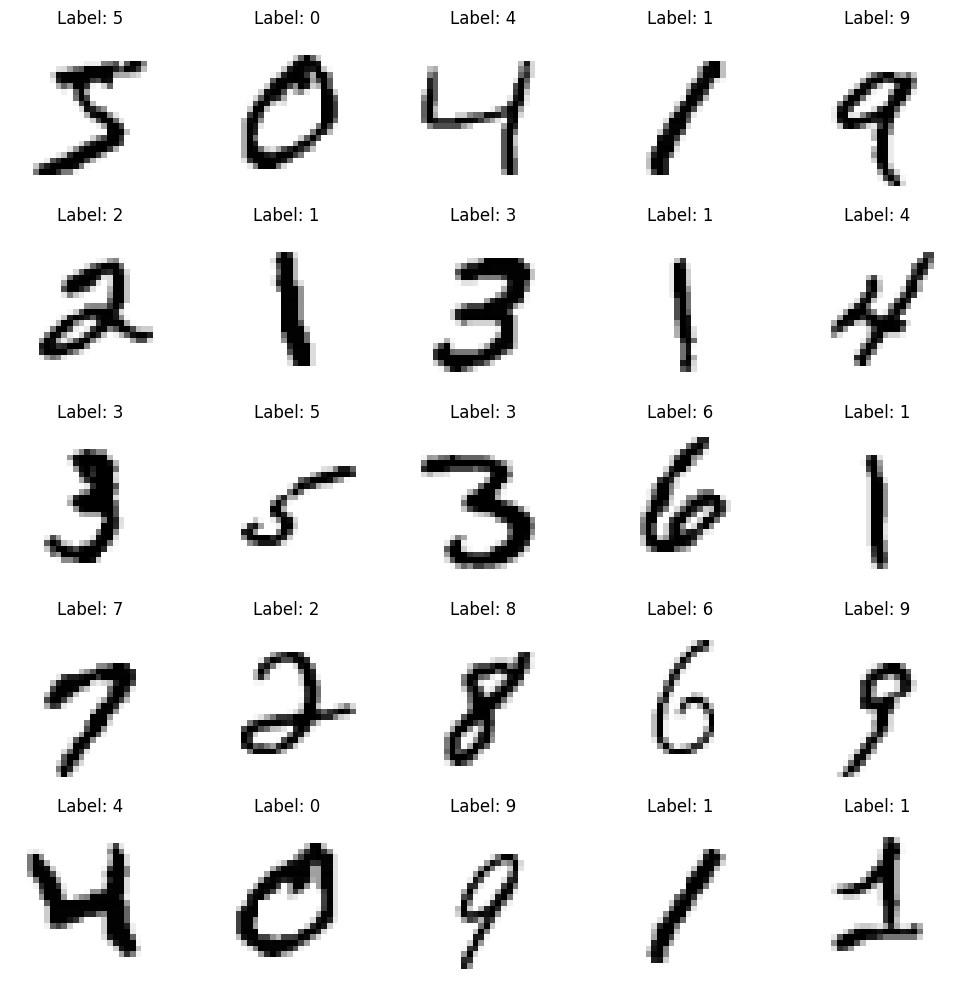

In [121]:
# Visualize some items in a grid
import matplotlib.pyplot as plt

fig, axs = plt.subplots(5, 5, figsize=(10,10))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(X_train[i], cmap="binary")
    ax.axis('off')
    ax.set_title(f"Label: {y_train[i]}")
plt.tight_layout()
plt.show()

In [122]:
X_train[0,]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,
         18,  18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,
          0,   0],
       [  

### Train/validation/test sets

In [148]:
# intentionally choose a small train set to decrease computational burden
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.8, random_state=prng)

print(f"X_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")
print(f"X_val:  {X_val.shape}")
print(f"y_val:  {y_val.shape}")
print(f"X_test:  {X_test.shape}")
print(f"y_test:  {y_test.shape}")

X_train: (12000, 28, 28)
y_train: (12000,)
X_val:  (48000, 28, 28)
y_val:  (48000,)
X_test:  (10000, 28, 28)
y_test:  (10000,)


### Benchmarks

In [124]:
# Benchmark #1 (silly):

from sklearn.metrics import accuracy_score
from statistics import mode

most_frequent = mode(y_train)
print(f"Most frequent element is: {most_frequent}")
accuracy_most_frequent = accuracy_score(y_val, np.repeat(most_frequent, len(y_val)))
print(f"Accuracy for our no-brainer model: {round(accuracy_most_frequent, 4)}")

Most frequent element is: 1
Accuracy for our no-brainer model: 0.1117


We can train a state-of-the-art machine learning model almost as easily. It can be used as our second benchmark. Note that our train data is multidimensional, instead of having `k` features, we have `ixj` features. In order to apply a standard ML algorithm, we need to flatten our data first. 

Since we need to apply the flattening to both the train and the test data, a clever way to do this is to build this step into the pipeline. Since we are applying the transformation to the whole feature matrix rather than specific columns, we can use the `FunctionTransformer`, which can apply any user-defined function to the feature matrix.

In [96]:
# Benchmark #2 (RF):
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import FunctionTransformer

def flatten_data(X):
    return X.reshape(X.shape[0], -1)

pipe_digit_rf = Pipeline([
    ("flatten", FunctionTransformer(flatten_data)),
    ("rf", RandomForestClassifier(random_state=prng))
])

pipe_digit_rf.fit(X_train, y_train)

predictions_rf = pipe_digit_rf.predict(X_val)
accuracy_rf = accuracy_score(y_val, predictions_rf)
print(f"Accuracy for RF: {round(accuracy_rf, 4)}")

Accuracy for RF: 0.9523


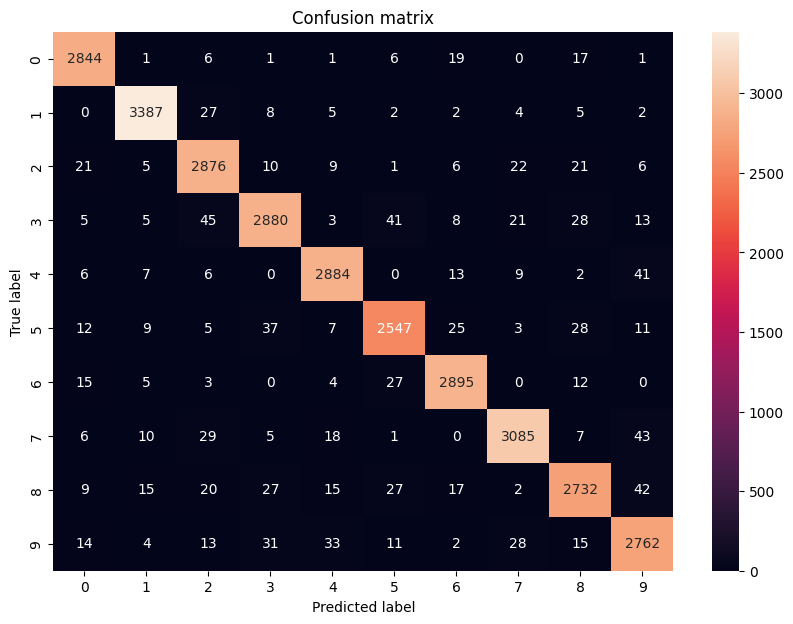

In [91]:
# Confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_val, predictions_rf)

# # visualize with seaborn
import seaborn as sns

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d")
plt.title("Confusion matrix")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

### Sklearn MLP

In [97]:
def scale_features(X):
    return X / 255

pipe_digit_mlp = Pipeline([
    ("flatten", FunctionTransformer(flatten_data)),
    ("scale", FunctionTransformer(scale_features)),
    ("mlp", MLPClassifier(random_state=prng))
])

pipe_digit_mlp.fit(X_train, y_train)
predictions_mlp = pipe_digit_mlp.predict(X_val)
accuracy_mlp = accuracy_score(y_val, predictions_mlp)
print(f"Accuracy for sklearn MLP: {round(accuracy_mlp, 4)}")

Accuracy for sklearn MLP: 0.9576


### Keras: simple model

While `scikit-learn` provides a wide range of machine learning algorithms, `keras` is specifically designed for building and training neural networks and deep learning models, making it more suitable for tasks involving complex patterns and large datasets. It offers several advanced features that `sklearn` does not, such as training networks with complex architectures (such as convolutional neural networks), or applying pre-processing techniques common to deep learning (such as scaling and flattening), or the ability to transfer learning from pre-trained networks.

Keras is a high-level neural network API that provides a simple and intuitive interface for building and training deep learning models. Keras can run on multiple backends, with TensorFlowTensor becoming the default. TensorFlow is a standalone, low-level deep learning library developed by Google.

In [149]:
# Convert target variables to categorical
num_classes = 10
y_sets = [y_train, y_test, y_val]
y_train, y_test, y_val = [to_categorical(y, num_classes=num_classes) for y in y_sets]

In [150]:
from keras.models import Sequential
from keras.layers import Input, Flatten, Rescaling, Dense
from keras.utils import to_categorical

# Build the model
model = Sequential()
model.add(Input(shape=X_train.shape[1:]))
model.add(Flatten())
model.add(Rescaling(1./255))
model.add(Dense(100, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())
# 784*100+100
# 100*10+10

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_11 (Flatten)            │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_11 (Rescaling)        │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 100)            │        78,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,510 (310.59 KB)

 Trainable params: 79,510 (310.59 KB)

 Non-trainable params: 0 (0.00 B)

None


The core of the backend is indeed constructed around **tensors**. Tensors are akin to NumPy arrays, as they hold numerical values of different dimensions. What sets them apart is their specialized role in deep learning: they are equipped with built-in gradient computation, seamlessly integrate within a computational graph, and are capable of leveraging hardware accelerators like TPUs and GPUs.

In [145]:
model.layers[3].output

<KerasTensor shape=(None, 10), dtype=float32, sparse=False, name=keras_tensor_125>

In [151]:
# Fit the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=512)

Epoch 1/10
60/60 - 1s - 19ms/step - accuracy: 0.7523 - loss: 0.9518 - val_accuracy: 0.8808 - val_loss: 0.4419
Epoch 2/10
60/60 - 0s - 7ms/step - accuracy: 0.8974 - loss: 0.3685 - val_accuracy: 0.9055 - val_loss: 0.3395
Epoch 3/10
60/60 - 0s - 8ms/step - accuracy: 0.9178 - loss: 0.2944 - val_accuracy: 0.9155 - val_loss: 0.2984
Epoch 4/10
60/60 - 1s - 11ms/step - accuracy: 0.9280 - loss: 0.2511 - val_accuracy: 0.9227 - val_loss: 0.2708
Epoch 5/10
60/60 - 1s - 9ms/step - accuracy: 0.9371 - loss: 0.2210 - val_accuracy: 0.9287 - val_loss: 0.2501
Epoch 6/10
60/60 - 1s - 9ms/step - accuracy: 0.9448 - loss: 0.1959 - val_accuracy: 0.9306 - val_loss: 0.2390
Epoch 7/10
60/60 - 1s - 9ms/step - accuracy: 0.9507 - loss: 0.1756 - val_accuracy: 0.9351 - val_loss: 0.2269
Epoch 8/10
60/60 - 1s - 10ms/step - accuracy: 0.9558 - loss: 0.1588 - val_accuracy: 0.9372 - val_loss: 0.2161
Epoch 9/10
60/60 - 0s - 8ms/step - accuracy: 0.9615 - loss: 0.1424 - val_accuracy: 0.9395 - val_loss: 0.2061
Epoch 10/10
60/6

In [152]:
# Evaluation of the model on the validation set
scores = model.evaluate(X_val, y_val)
print(f"Accuracy for keras MLP: {round(scores[1], 4)}")

1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 988us/step - accuracy: 0.9414 - loss: 0.2024
Accuracy for keras MLP: 0.9415


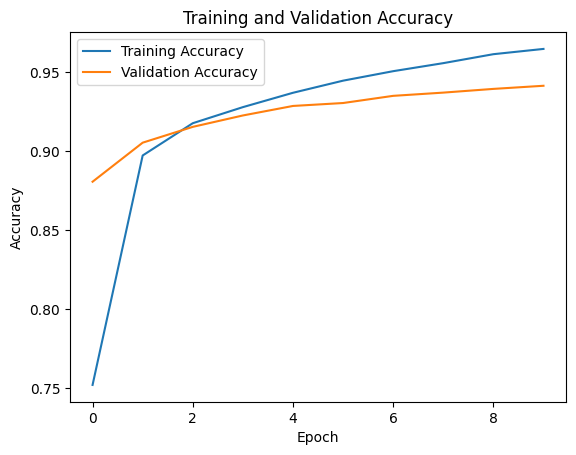

In [162]:
def plot_history(fit_history):
    plt.plot(fit_history['accuracy'], label='Training Accuracy')
    plt.plot(fit_history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    plt.show()

plot_history(history.history)

It seems that the maximum is not yet found. Let's train the network a little bit longer. Note that unless we recompile the model, the process starts from the point where it previously ended.

In [154]:
history_longer_train = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=512)

Epoch 1/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9693 - loss: 0.1184 - val_accuracy: 0.9432 - val_loss: 0.1939
Epoch 2/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9720 - loss: 0.1100 - val_accuracy: 0.9435 - val_loss: 0.1912
Epoch 3/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9757 - loss: 0.0951 - val_accuracy: 0.9458 - val_loss: 0.1865
Epoch 4/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9788 - loss: 0.0892 - val_accuracy: 0.9458 - val_loss: 0.1839
Epoch 5/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9797 - loss: 0.0827 - val_accuracy: 0.9473 - val_loss: 0.1803
Epoch 6/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9805 - loss: 0.0785 - val_accuracy: 0.9470 - val_loss: 0.1799
Epoch 7/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9830 - loss: 0.0692 - val_accuracy: 0.9485 - val_loss: 0.1765
Epoch 8/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9856 - loss: 0.0633 - val_accuracy: 0.9491 - val_loss

In [163]:
total_history = {
    "accuracy": history.history["accuracy"] + history_longer_train.history["accuracy"],
    "val_accuracy": history.history["val_accuracy"] + history_longer_train.history["val_accuracy"],
}

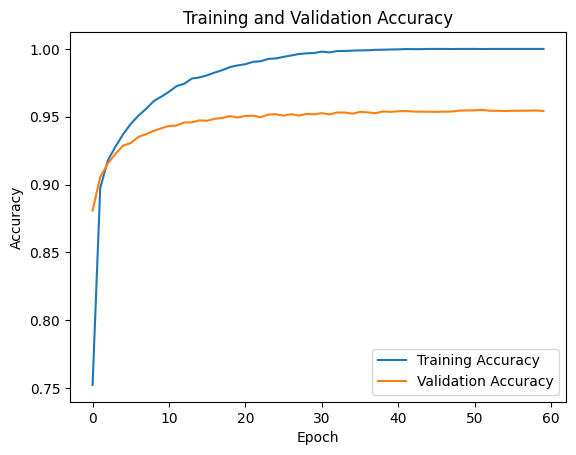

In [164]:
plot_history(total_history)

In [168]:
model.evaluate(X_val, y_val)

1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9580 - loss: 0.1974


[0.1923033446073532, 0.9577916860580444]

### Regularization in neural networks

In [165]:
from keras.layers import Dropout

# Build the model
model = Sequential()
model.add(Input(shape=X_train.shape[1:]))
model.add(Flatten())
model.add(Rescaling(1./255))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_12 (Flatten)            │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_12 (Rescaling)        │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 100)            │        78,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,510 (310.59 KB)

 Trainable params: 79,510 (310.59 KB)

 Non-trainable params: 0 (0.00 B)

None


In [166]:
history_regularized = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=512)

Epoch 1/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.4487 - loss: 1.6577 - val_accuracy: 0.8696 - val_loss: 0.5300
Epoch 2/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8199 - loss: 0.6273 - val_accuracy: 0.8985 - val_loss: 0.3871
Epoch 3/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8634 - loss: 0.4690 - val_accuracy: 0.9110 - val_loss: 0.3280
Epoch 4/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8809 - loss: 0.4072 - val_accuracy: 0.9176 - val_loss: 0.2969
Epoch 5/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8962 - loss: 0.3687 - val_accuracy: 0.9249 - val_loss: 0.2710
Epoch 6/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9117 - loss: 0.3283 - val_accuracy: 0.9288 - val_loss: 0.2531
Epoch 7/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9040 - loss: 0.3223 - val_accuracy: 0.9317 - val_loss: 0.2390
Epoch 8/100
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.9208 - loss: 0.2833 - val_accuracy: 0.9342 

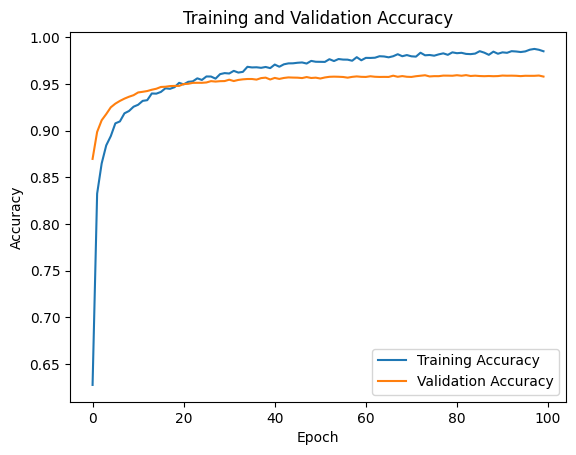

In [167]:
plot_history(history_regularized.history)

### Keras: Deep network

In [169]:
# Build the model
deep_model = Sequential()
deep_model.add(Input(shape=X_train.shape[1:]))
deep_model.add(Flatten())
deep_model.add(Rescaling(1./255))
deep_model.add(Dense(256, activation='relu'))
deep_model.add(Dropout(0.5))
deep_model.add(Dense(256, activation='relu'))
deep_model.add(Dropout(0.5))
deep_model.add(Dense(num_classes, activation='softmax'))

# Compile the deep_model
deep_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(deep_model.summary())
# 784*256+256
# 256*256+256
# 256*10+10

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_13 (Flatten)            │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_13 (Rescaling)        │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 269,322 (1.03 MB)

 Trainable params: 269,322 (1.03 MB)

 Non-trainable params: 0 (0.00 B)

None


In [170]:
history_deep = deep_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=512)

Epoch 1/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.4746 - loss: 1.5613 - val_accuracy: 0.8856 - val_loss: 0.3993
Epoch 2/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.8393 - loss: 0.5136 - val_accuracy: 0.9157 - val_loss: 0.2828
Epoch 3/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8873 - loss: 0.3629 - val_accuracy: 0.9288 - val_loss: 0.2382
Epoch 4/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9104 - loss: 0.2921 - val_accuracy: 0.9374 - val_loss: 0.2090
Epoch 5/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9275 - loss: 0.2492 - val_accuracy: 0.9407 - val_loss: 0.1965
Epoch 6/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9322 - loss: 0.2247 - val_accuracy: 0.9483 - val_loss: 0.1744
Epoch 7/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.9391 - loss: 0.1935 - val_accuracy: 0.9473 - val_loss: 0.1728
Epoch 8/50
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9436 - loss: 0.1867 - val_accuracy: 0.9520 - v

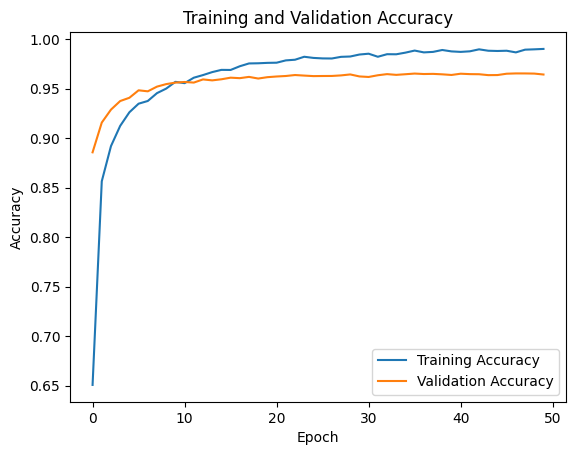

In [171]:
plot_history(history_deep.history)

### Convolution with keras

Convolutional layers are designed to operate on images or time-series data with multiple sensors, so they expect input data to have a channel dimension. In our case, since we are dealing with grayscale images, we will have only one channel (unlike the RGB channels in color images). To ensure our data has this channel dimension, we need to reshape our data first.

In [178]:
X_train.shape[1]

28

In [193]:
from keras.layers import Reshape, Conv2D, MaxPooling2D

# Build the model
model_cnn = Sequential()
model_cnn.add(Input(shape=X_train.shape[1:]))
model_cnn.add(Rescaling(1./255))
model_cnn.add(Reshape(target_shape=(X_train.shape[1], X_train.shape[2], 1)))
model_cnn.add(Conv2D(32, (3, 3), activation='relu'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))
model_cnn.add(Conv2D(64, (3, 3), activation='relu'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))
model_cnn.add(Flatten())
model_cnn.add(Dropout(0.5))
model_cnn.add(Dense(num_classes, activation='softmax'))

# Compile the model
model_cnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model_cnn.summary())
# 32*(3*3+1)
# 64*(32*3*3+1) -- bias term is not channel-specific as it does not depend on the input data
# (64*5*5)*10+10


Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_14 (Rescaling)        │ (None, 28, 28)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_7 (Reshape)             │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_21 (Flatten)            │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 10)             │        16,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,826 (136.04 KB)

 Trainable params: 34,826 (136.04 KB)

 Non-trainable params: 0 (0.00 B)

None


In [194]:
# Fit the model
history_cnn = model_cnn.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=512)

Epoch 1/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 125ms/step - accuracy: 0.4870 - loss: 1.7213 - val_accuracy: 0.8918 - val_loss: 0.3773
Epoch 2/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 7s 123ms/step - accuracy: 0.8805 - loss: 0.3940 - val_accuracy: 0.9404 - val_loss: 0.2106
Epoch 3/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 7s 118ms/step - accuracy: 0.9268 - loss: 0.2354 - val_accuracy: 0.9548 - val_loss: 0.1549
Epoch 4/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 7s 122ms/step - accuracy: 0.9415 - loss: 0.1838 - val_accuracy: 0.9635 - val_loss: 0.1265
Epoch 5/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 8s 135ms/step - accuracy: 0.9526 - loss: 0.1547 - val_accuracy: 0.9680 - val_loss: 0.1091
Epoch 6/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 8s 138ms/step - accuracy: 0.9619 - loss: 0.1174 - val_accuracy: 0.9710 - val_loss: 0.0984
Epoch 7/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 8s 128ms/step - accuracy: 0.9630 - loss: 0.1149 - val_accuracy: 0.9731 - val_loss: 0.0906
Epoch 8/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 7s 116ms/step - accuracy: 0.9681 - loss: 0.1013 - val_accuracy: 0.

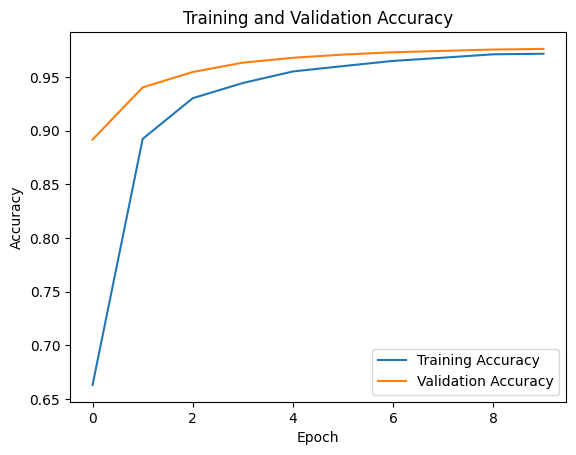

In [195]:
plot_history(history_cnn.history)

### Other useful tricks: data augmentation

- `train_generator`: This creates an instance of the ImageDataGenerator class, which will generate augmented training data batches. It's initialized with various data augmentation settings:

    - `rescale = 1./255`: This scales down the pixel values of the images to a range between 0 and 1, which is a common normalization step for image data.
    - `rotation_range = 40`: Images will be randomly rotated by angles between -40 and 40 degrees during augmentation.
    - `shear_range` = 0.2: Random shear transformations will be applied with a maximum shear intensity of 0.2.
    - `zoom_range` = 0.2: Random zooming with a maximum zoom factor of 0.2 will be performed.
    - `fill_mode` = 'nearest': This determines how new pixels created by transformations will be filled. 'nearest' means new pixels take the value of the nearest existing pixel.

- `val_generator`: This creates another instance of ImageDataGenerator, intended for generating validation data batches. It only includes normalization by rescaling pixel values to the range of 0 to 1, without the augmentation settings.

- `train_iterator`: This is an iterator created from the training generator. It generates batches of augmented training data by applying the transformations specified in train_generator to the input images `X_train` and corresponding labels `y_train`. Key points:

    - `X_train` and `y_train` are the training images and labels.
    - `batch_size=512`: This specifies how many samples are in each batch.
    - `shuffle=True`: Batches will be shuffled before being presented to the model, which helps with randomness and avoiding overfitting.

- `val_iterator`: Similar to the train_iterator, this iterator generates batches of validation data using the validation generator. Key points:

    - `X_val` and `y_val` are the validation images and labels.
    - `batch_size=512`: The number of samples in each validation batch.
    - `shuffle=False`: Since shuffling isn't necessary during validation, this is set to False to maintain the order of the validation data.

In [204]:
# data augmentation with generator
from tensorflow.keras.preprocessing.image import ImageDataGenerator

reshape_layer = Reshape((X_train.shape[1], X_train.shape[1], 1), input_shape = X_train.shape[1:])

train_generator = ImageDataGenerator(
    rescale = 1./255,  # normalization of images
    rotation_range = 40, # augmention of images to avoid overfitting
    shear_range = 0.2,
    zoom_range = 0.2,
    fill_mode = 'nearest'
)

val_generator = ImageDataGenerator(rescale = 1./255)

train_iterator = train_generator.flow(reshape_layer(X_train), y_train, batch_size=512, shuffle=True)

val_iterator = val_generator.flow(reshape_layer(X_val), y_val, batch_size=512, shuffle=False)

ValueError: The total size of the tensor must be unchanged. Received: input_shape=(28, 28), target_shape=(28, 28, 3)

In [200]:
from tensorflow.keras.applications.resnet50 import ResNet50

transfer_model = Sequential()
# add the pretrained model
transfer_model.add(ResNet50(include_top=False, pooling='avg', weights='imagenet'))
# add fully connected layer with output
transfer_model.add(Dense(512, activation='relu'))
transfer_model.add(Dense(10, activation='softmax'))

# set resnet layers not trainable
transfer_model.layers[0].trainable=False
transfer_model.summary()

Model: "sequential_28"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ ?                      │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

In [202]:
transfer_model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [203]:
transfer_model.fit(train_iterator, epochs=10, validation_data=val_iterator)

Epoch 1/10


ValueError: Exception encountered when calling Functional.call().

[1mInput 0 of layer "conv1_conv" is incompatible with the layer: expected axis -1 of input shape to have value 3, but received input with shape (None, 34, 34, 1)[0m

Arguments received by Functional.call():
  • inputs=tf.Tensor(shape=(None, 28, 28, 1), dtype=float32)
  • training=True
  • mask=None

### Evaluate our final model on the test set

### Transfer learning